In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, ResNet101
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os


In [2]:
# Set seed for reproducibility
def set_seed(seed=42):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


In [3]:
# Specify the classes to include
selected_classes = {"Diabetic Retinopathy", "Glaucoma", "Healthy", "Macular Scar", "Myopia"}

# Define paths for train, validation, and test datasets
train_dataset_path = "/kaggle/input/aug-v100/output"
val_dataset_path = "/kaggle/input/aug-v100/val"
test_dataset_path = "/kaggle/input/aug-v100/test"


In [4]:
# Helper function to filter available classes
def filter_classes(data_dir, selected_classes):
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory not found: {data_dir}")
    available_classes = set(os.listdir(data_dir))
    filtered_classes = available_classes.intersection(selected_classes)
    return [cls for cls in filtered_classes if os.path.isdir(os.path.join(data_dir, cls))]


In [5]:
# Filter classes for train, validation, and test datasets
filtered_train_classes = filter_classes(train_dataset_path, selected_classes)
filtered_val_classes = filter_classes(val_dataset_path, selected_classes)
filtered_test_classes = filter_classes(test_dataset_path, selected_classes)


In [6]:
# Check if any classes are available
if not filtered_train_classes or not filtered_val_classes or not filtered_test_classes:
    raise ValueError("No matching classes found in the dataset directories!")

# Set the number of classes
num_classes = len(filtered_train_classes)


In [7]:
# Load datasets using image_dataset_from_directory
def load_dataset(path, classes):
    return tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='int',
        class_names=classes,
        batch_size=64,
        image_size=(224, 224)
    )

train_dataset = load_dataset(train_dataset_path, filtered_train_classes)
val_dataset = load_dataset(val_dataset_path, filtered_val_classes)
test_dataset = load_dataset(test_dataset_path, filtered_test_classes)


Found 5131 files belonging to 5 classes.
Found 484 files belonging to 5 classes.
Found 482 files belonging to 5 classes.


In [8]:
# Normalize the datasets
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


In [9]:

# Prepare datasets for two inputs
def prepare_inputs(image, label):
    return {"xception_input_1_C": image, "xception_input_2": image}, label

train_dataset = train_dataset.map(prepare_inputs).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(prepare_inputs).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(prepare_inputs).prefetch(tf.data.AUTOTUNE)


In [10]:
# Define Xception branches
xception_input_1 = Input(shape=(224, 224, 3), name="xception_input_1")
xception_input_2 = Input(shape=(224, 224, 3), name="xception_input_2")


In [11]:
# First Xception branch
with tf.name_scope("xception_1"):
    xception_base_1 = Xception(weights="imagenet", include_top=False, input_tensor=xception_input_1)
    for layer in xception_base_1.layers:
        layer.name = layer.name + str('_C')
    xception_output_1 = GlobalAveragePooling2D(name="xception_1_gap")(xception_base_1.output)

# Second Xception branch
with tf.name_scope("xception_2"):
    xception_base_2 = Xception(weights="imagenet", include_top=False, input_tensor=xception_input_2)
    xception_output_2 = GlobalAveragePooling2D(name="xception_2_gap")(xception_base_2.output)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Concatenate outputs
combined_output = concatenate([xception_output_1, xception_output_2], name="combined_output")

# Add fully connected layer and output
final_output = Dense(num_classes, activation="softmax", name="final_output")(combined_output)

# Define model
model = Model(inputs=[xception_input_1, xception_input_2], outputs=final_output)

In [13]:
# ************************************************************************
# Set pretrained layers to non-trainable
for layer in xception_base_1.layers:
    layer.trainable = False
for layer in xception_base_2.layers:
    layer.trainable = False
# ************************************************************************

In [14]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
# Train the model
num_epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_ensemble_model.keras", save_best_only=True, monitor="val_accuracy"),
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, restore_best_weights=True)
    ]
)

Epoch 1/50


I0000 00:00:1737201652.844157      73 service.cc:145] XLA service 0x7d047c002520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737201652.844214      73 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1737201652.844218      73 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1737201675.015226      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 107s 871ms/step - accuracy: 0.5045 - loss: 1.2408 - val_accuracy: 0.6405 - val_loss: 0.9393
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 52s 615ms/step - accuracy: 0.6533 - loss: 0.8828 - val_accuracy: 0.6260 - val_loss: 0.9803
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 50s 600ms/step - accuracy: 0.6639 - loss: 0.8405 - val_accuracy: 0.6467 - val_loss: 0.8608
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 50s 596ms/step - accuracy: 0.6842 - loss: 0.7948 - val_accuracy: 0.6364 - val_loss: 0.8692
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 51s 610ms/step - accuracy: 0.6815 - loss: 0.7679 - val_accuracy: 0.6570 - val_loss: 0.8717
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 50s 595ms/step - accuracy: 0.7045 - loss: 0.7410 - val_accuracy: 0.6529 - val_loss: 0.8545
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 52s 612ms/step - accuracy: 0.7281 - loss: 0.7071 - val_accuracy: 0.7004 - val_loss: 0.8187
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 50s 596ms/step - accuracy: 0.7194 - loss: 0.6992 - val_accuracy: 0.66

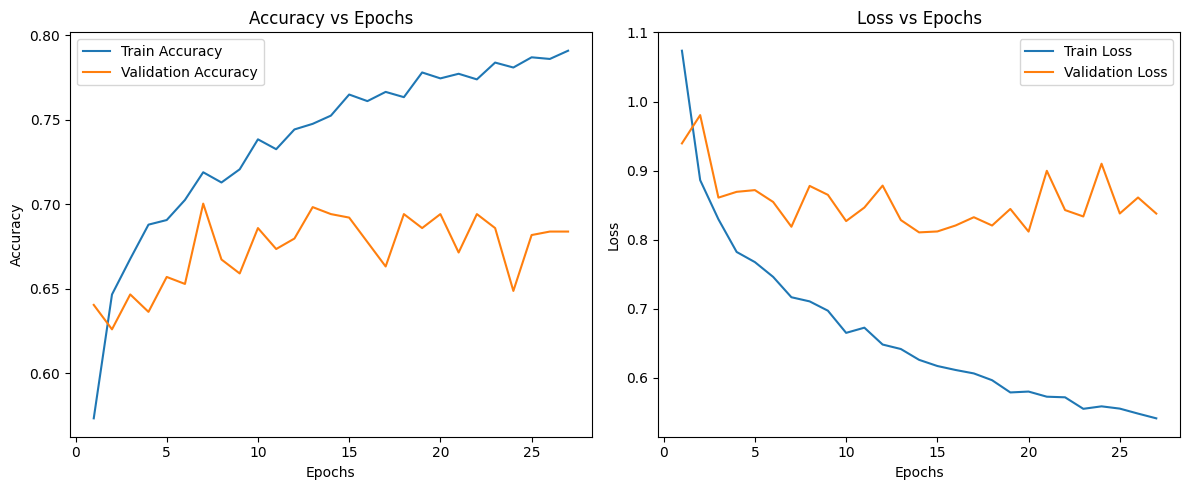

In [16]:
# Plot training and validation metrics
def plot_training_history(history):
    epochs = range(1, len(history.history["accuracy"]) + 1)
    
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["accuracy"], label="Train Accuracy")
    plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["loss"], label="Train Loss")
    plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)



In [17]:
import numpy as np
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [18]:
# Load the best model
best_model = tf.keras.models.load_model("best_ensemble_model.keras")

# Evaluate on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6963 - loss: 0.7917
Test Loss: 0.7803, Test Accuracy: 70.33%


In [19]:
# Generate predictions and true labels
y_true = []
y_pred = []

for data, labels in test_dataset:
    y_true.extend(labels.numpy())  # Append true labels
    preds = np.argmax(best_model.predict(data), axis=-1)  # Predict and take the class with max probability
    y_pred.extend(preds)


2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [20]:
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
class_report = classification_report(
    y_true,
    y_pred,
    target_names=selected_classes,
    digits=4
)
print("\nClassification Report:")
print(class_report)



Classification Report:
                      precision    recall  f1-score   support

            Glaucoma     0.5926    0.3636    0.4507        44
        Macular Scar     0.8725    0.8609    0.8667       151
Diabetic Retinopathy     0.6069    0.6519    0.6286       135
             Healthy     0.6262    0.6569    0.6411       102
              Myopia     0.7037    0.7600    0.7308        50

            accuracy                         0.7033       482
           macro avg     0.6804    0.6587    0.6636       482
        weighted avg     0.7029    0.7033    0.7002       482



In [21]:
# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)


Cohen's Kappa: 0.6071


In [22]:
# Sensitivity (Recall per class)
sensitivity_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nSensitivity per class:")
for i, class_name in enumerate(selected_classes):
    print(f"{class_name}: {sensitivity_per_class[i]:.4f}")

# F1 score
f1_scores = 2 * (sensitivity_per_class * sensitivity_per_class) / (sensitivity_per_class + sensitivity_per_class)
print("\nF1 Scores per class (for reference):")
for i, class_name in enumerate(selected_classes):
    print(f"{class_name}: {f1_scores[i]:.4f}")


Sensitivity per class:
Glaucoma: 0.3636
Macular Scar: 0.8609
Diabetic Retinopathy: 0.6519
Healthy: 0.6569
Myopia: 0.7600

F1 Scores per class (for reference):
Glaucoma: 0.3636
Macular Scar: 0.8609
Diabetic Retinopathy: 0.6519
Healthy: 0.6569
Myopia: 0.7600


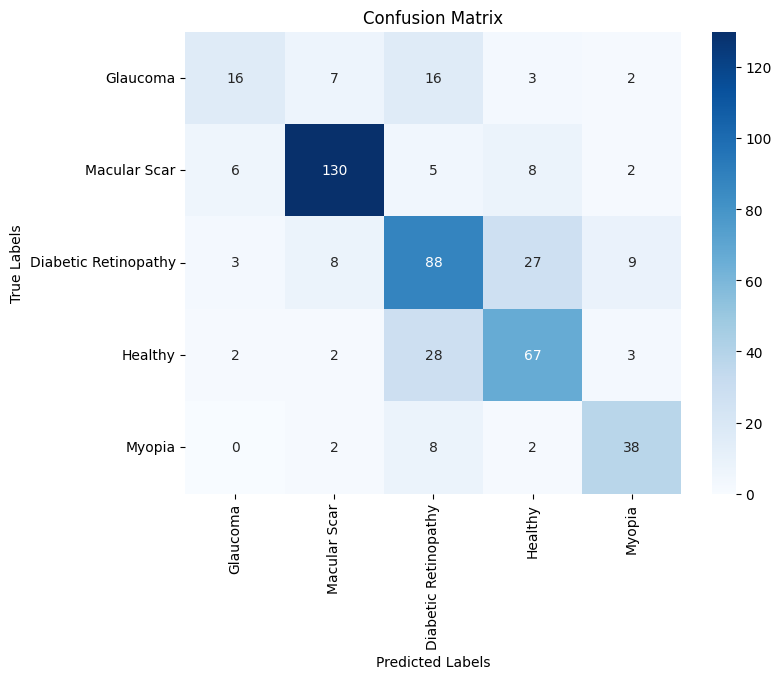

In [23]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()